# Library

In [83]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

# LightGBM

In [72]:
df = pd.read_parquet('../ResultsBERTopic/BERTopic_nodefinedcluster_topics_15n_10com_1200cluster_0.64sil_renewout.parquet')
df.head()

,Document,Embedding,Topic,Probability,Created_on,Count,Name,Representation,Representative_Docs,UMAP_embedding
0,checks,"[0.052164897, 0.029597273, -0.03666609, 0.0051...",4,0.000000,2020-01-09,6299,4_mdma_lsd_get_looking,"[mdma, lsd, get, looking, wsm, good, btc, ques...","[hey ro im gon na pull pk, life wonderful life...","[1.6488198, 9.914265, 1.442794, 2.8094368, -0...."
1,trusted vendor status,"[0.02445144, -0.008732641, -0.0050215074, 0.01...",2,0.944247,2020-01-09,6907,2_vendor_scammer_scam_looking,"[vendor, scammer, scam, looking, scamming, sal...","[looking good reliable vendor sell ounce, vend...","[2.910516, 10.281041, 1.650234, 3.0320778, -0...."
2,empire exit scam iiflux user incomming,"[0.02890829, 0.036081452, -0.027694924, -0.007...",1,1.000000,2019-11-06,6236,1_market_empire_dream_nightmare,"[market, empire, dream, nightmare, vendor, dre...","[next market, dream market vendor rstclass nig...","[1.5884036, 9.8587885, 3.3090453, 2.652358, 2...."
3,ecstasy vendor packs,"[-0.022524439, 0.03949761, -0.023750877, 0.033...",5,0.797741,2020-01-09,2776,5_order_package_shipping_delivery,"[order, package, shipping, delivery, pack, shi...",[order accepted day still hasnt marked shipped...,"[2.0245404, 10.517631, 2.3443217, 3.7595236, -..."
4,opening bank account person fake id,"[-0.029834118, 0.03354508, -0.012210185, -0.02...",6,1.000000,2019-11-06,2823,6_bitcoin_card_wallet_btc,"[bitcoin, card, wallet, btc, bank, credit, car...","[credit cards paypal prepaid card find, got cc...","[0.7278271, 9.884823, 1.8116106, 2.9336705, -0..."


In [73]:
df = df[['Topic', 'Embedding']]
df['Topic'] = df['Topic'].astype(int)

In [74]:
embedding_dim = len(df['Embedding'][0])
embedding_cols = pd.DataFrame(df['Embedding'].tolist(), index=df.index, columns=[f'embedding_{i}' for i in range(embedding_dim)])
df = pd.concat([df, embedding_cols], axis=1)

In [75]:
X = df.drop(columns=['Topic', 'Embedding'])
y = df["Topic"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [76]:
X

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_502,embedding_503,embedding_504,embedding_505,embedding_506,embedding_507,embedding_508,embedding_509,embedding_510,embedding_511
0,0.052165,0.029597,-0.036666,0.005138,-0.059532,-0.015650,0.013078,-0.081077,0.035621,0.012535,...,0.033409,-0.014622,-0.004541,0.018409,-0.082881,-0.076264,-0.019555,-0.003789,0.010424,-0.043819
1,0.024451,-0.008733,-0.005022,0.016146,0.036557,-0.047461,0.043232,-0.008118,-0.028329,-0.000895,...,-0.016856,0.000671,-0.009592,0.021385,0.010102,-0.034871,0.035009,-0.039954,-0.066903,-0.040152
2,0.028908,0.036081,-0.027695,-0.007742,0.082766,-0.025883,-0.020068,-0.045522,-0.055110,0.030849,...,-0.006413,0.071259,-0.053650,-0.007399,0.000118,0.034137,0.032269,-0.063775,-0.013668,-0.022599
3,-0.022524,0.039498,-0.023751,0.033864,0.047827,0.027267,-0.003001,-0.044979,-0.113779,0.030676,...,0.033887,0.027084,0.002074,0.042919,-0.019398,-0.017992,0.083440,-0.006578,-0.006482,0.016723
4,-0.029834,0.033545,-0.012210,-0.024906,0.049844,-0.004193,-0.038041,-0.015139,0.010674,0.003973,...,0.054935,0.020359,0.042316,0.028488,0.019320,-0.053694,-0.050532,-0.041695,-0.034651,-0.026589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37911,-0.045250,0.050984,-0.072840,0.047013,0.028561,-0.046705,-0.007550,-0.009371,0.021440,0.006635,...,0.055253,0.072550,0.109431,0.045203,-0.026831,0.055549,-0.017548,-0.013224,-0.030828,-0.025209
37912,0.034510,-0.021323,0.004125,-0.008919,0.040639,-0.004188,-0.022752,0.015768,0.017665,0.036704,...,0.070114,-0.005231,0.040585,0.054636,-0.002345,0.017009,0.064466,0.017172,-0.014565,0.025122
37913,-0.015157,0.011035,-0.007611,-0.026127,0.016410,-0.000551,-0.065369,0.044574,-0.025546,0.023765,...,0.062351,-0.008425,-0.015304,0.034309,-0.061661,0.048315,0.074207,-0.011618,-0.046587,0.050120
37914,0.012141,-0.000476,-0.030872,0.053040,0.028541,-0.028295,-0.042285,-0.017961,-0.065212,0.013701,...,0.022345,0.048772,0.013783,0.019187,0.030875,-0.031955,0.038450,-0.030933,-0.029847,-0.004253


## Training

In [ ]:
params = {
    'objective': 'multiclass',
    'num_class': len(y.unique()),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}

bst = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=1000)

## Evaluation

In [87]:
y_pred = bst.predict(X_test)
y_pred_max = [np.argmax(line) for line in y_pred]
print(classification_report(y_test, y_pred_max))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1797
           1       0.97      0.97      0.97      1196
           2       0.96      0.95      0.96      1396
           3       0.98      0.98      0.98       864
           4       0.95      0.97      0.96      1247
           5       0.96      0.92      0.94       520
           6       0.96      0.94      0.95       564

    accuracy                           0.96      7584
   macro avg       0.96      0.96      0.96      7584
weighted avg       0.96      0.96      0.96      7584



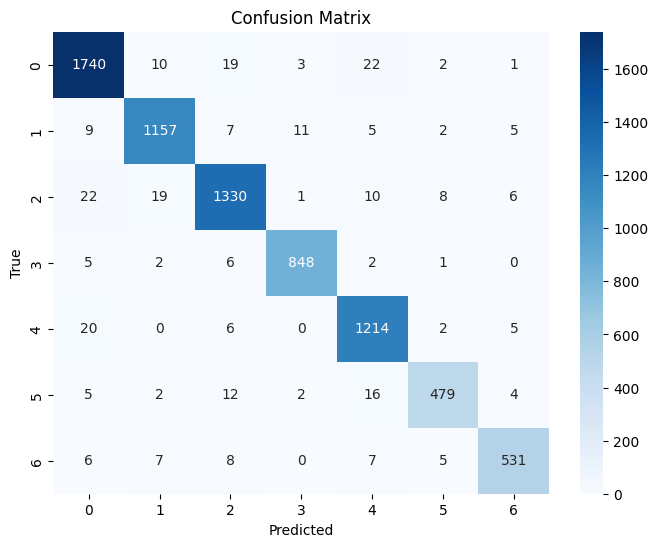

In [81]:
cm = confusion_matrix(y_test, y_pred_max)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

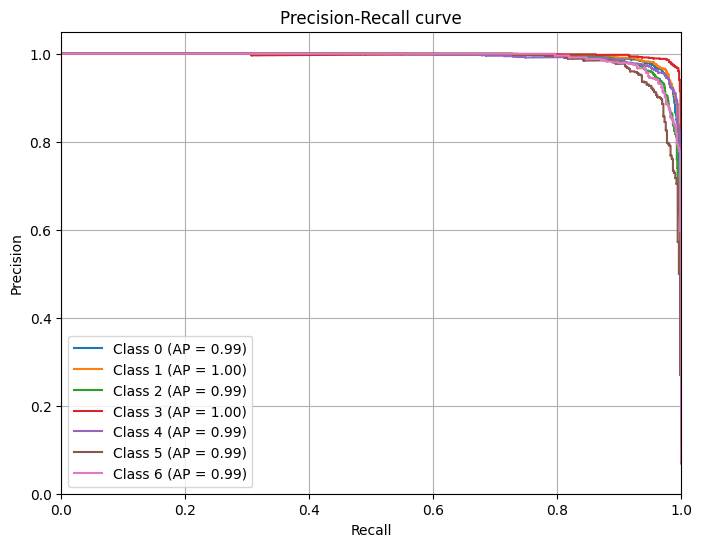

In [85]:
classes=[0, 1, 2, 3, 4, 5, 6]
y_test_bin = label_binarize(y_test, classes=classes)
precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_pred[:, i])
    
plt.figure(figsize=(8, 6))
plt.step(recall[0], precision[0], where='post', label='Class 0 (AP = {:.2f})'.format(average_precision[0]))
plt.step(recall[1], precision[1], where='post', label='Class 1 (AP = {:.2f})'.format(average_precision[1]))
plt.step(recall[2], precision[2], where='post', label='Class 2 (AP = {:.2f})'.format(average_precision[2]))
plt.step(recall[3], precision[3], where='post', label='Class 3 (AP = {:.2f})'.format(average_precision[3]))
plt.step(recall[4], precision[4], where='post', label='Class 4 (AP = {:.2f})'.format(average_precision[4]))
plt.step(recall[5], precision[5], where='post', label='Class 5 (AP = {:.2f})'.format(average_precision[5]))
plt.step(recall[6], precision[6], where='post', label='Class 6 (AP = {:.2f})'.format(average_precision[6]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## Predict Example